# Climate Stripes

Climate stripes are a powerful visualization tool that can quickly convey long-term trends in temperature. In this notebook, we'll be exploring the yearly rolling temperature of Berlin, Prague, Reykjavik, Lisboa, Madrid, Milan, Stockholm, Vienna, and Zurich from 1949-2022, sourced from the European Climate Assessment & Dataset (ECA&D).

### Import Modules

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##  Read the data into a DataFrame

In [94]:
# Load Data
df = pd.read_csv('data/eca/germany-berlin.txt', delimiter=',')
df.columns = df.columns.str.strip()

## Time Axis

In [95]:
# Extract Year and Month from Date
df['year'] = df['DATE'].astype(str).str.slice(0, 4)
df['month'] = df['DATE'].astype(str).str.slice(4, 6)
# Set date as index
df = df.set_index(pd.to_datetime(df['DATE'], format='%Y%m%d'))
df = df.rename_axis(None)

## Data Wrangling

The TG column contains the temperature measured in 0.1 Celsius degrees. This was probably established decades ago when disk space and memory were more expensive (integers take less space). Create a new column by dividing the temperature by 10.

We write a function `replace_missing_celsius` to replace missing values Instead of the median, you could average over the year before and after the gap or take the mean of exactly the same day of the adjacent years.

In [96]:
df['celsius'] = df['TG'] /  10
#print(df) -999.9 means missing value
def replace_missing_celsius(df):
    missing_rows = df.loc[df['celsius'] == -999.9]
    if len(missing_rows) == 0:
        return df
    for index, row in missing_rows.iterrows():
        prev_year_celsius = None
        year = index.year
        while prev_year_celsius is None and year >= df.index.min().year:
            try:
                prev_year_celsius = df.loc[f'{year-1}-{index.month}-{index.day}']['celsius']
            except KeyError:
                # Handle leap year
                if index.month == 2 and index.day == 29:
                    prev_year_celsius = df.loc[f'{year-1}-02-28']['celsius']
                year -= 1
        if prev_year_celsius is None:
            prev_year_celsius = 0
        df.at[index, 'celsius'] = prev_year_celsius
    return replace_missing_celsius(df)

df = replace_missing_celsius(df)

## Calculating median temperatures

In [97]:
# Slice DataFrame to only include dates up until the end of the previous year
df_1949_2022 = df.loc['1949-01-01':'2022-12-31']

# Calculate median temperatures based on modified DataFrame
df_median_temps = df_1949_2022.groupby('year')['celsius'].median()
berlin_avg_celsius = df_median_temps.tolist()

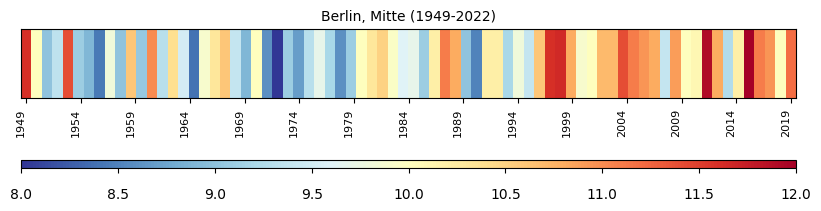

In [98]:
# Define the color map and normalization
cmap = plt.cm.get_cmap('RdYlBu_r')
norm = plt.Normalize(np.min(berlin_avg_celsius), np.max(berlin_avg_celsius))
fig, ax = plt.subplots(figsize=(10, 2))
image = ax.imshow([berlin_avg_celsius], cmap=cmap, aspect='auto', norm=norm)
cbar = plt.colorbar(image, ax=ax, orientation='horizontal', pad=0.4, aspect=90)
cbar.ax.tick_params(labelsize=10)
cbar.ax.tick_params(axis='x', pad=10)  # add a margin on top
years = np.arange(1949, 2022, 5)
ax.set_xticks(np.linspace(0, len(berlin_avg_celsius)-1, len(years)))
ax.set_xticklabels(years, fontsize=8, rotation=90, ha='right')
ax.set_yticks([])
ax.set_ylabel('')
plt.title('Berlin, Mitte (1949-2022)', fontsize=10)
plt.show()

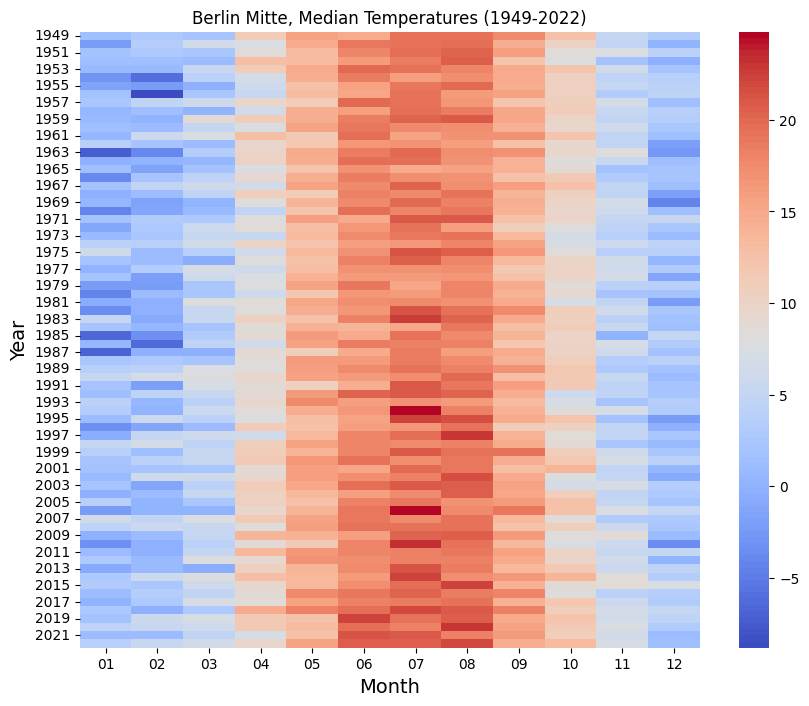

In [99]:
df_1949_01_2022_12 = df_1949_2022.groupby(['year', 'month'])['celsius'].median().unstack()

fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.get_cmap('coolwarm', 100)

sns.heatmap(df_1949_01_2022_12, cmap=cmap, ax=ax)

# Set title and axis labels
ax.set_title('Berlin Mitte, Median Temperatures (1949-2022)', fontsize=12)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Year', fontsize=14)

# Show plot
plt.show()
